In [1]:
!pip install -q monai
!pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import sys
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' # specify GPUs locally

# libraries
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import random

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
from sklearn.metrics import roc_auc_score
import albumentations

import monai
from monai.data import NiftiDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor

# from apex import amp # I cannot install apex in Kagggle notebook

device = torch.device('cuda')

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    
set_seed(0)

In [3]:
DEBUG = True

kernel_type = 'monai3d_160_3ch_1e-5_20ep_aug'

image_size = 200
use_amp = False
data_dir = '../input/rsna-str-pe-detection-jpeg-256/train-jpegs'
num_workers = 4
init_lr = 1e-5
out_dim = 9
freeze_epo = 0
warmup_epo = 5
cosine_epo = 7 if DEBUG else 19
n_epochs = freeze_epo + warmup_epo + cosine_epo

In [4]:
target_cols = [
        'negative_exam_for_pe', # exam level
        'rv_lv_ratio_gte_1', # exam level
        'rv_lv_ratio_lt_1', # exam level
        'leftsided_pe', # exam level
        'chronic_pe', # exam level
        'rightsided_pe', # exam level
        'acute_and_chronic_pe', # exam level
        'central_pe', # exam level
        'indeterminate' # exam level
    ]

In [5]:
df = pd.read_csv('../input/rsna-str-pulmonary-embolism-detection/train.csv')

from sklearn.model_selection import GroupKFold
np.random.seed(0)
group_kfold = GroupKFold(n_splits=5)
print(group_kfold)

df['fold'] = -1
for i, (_, val_index) in enumerate(group_kfold.split(df, groups=df.StudyInstanceUID)):
    df.loc[val_index, 'fold'] = i

df.fold.value_counts()

GroupKFold(n_splits=5)


2    358142
4    358138
1    358127
0    358125
3    358062
Name: fold, dtype: int64

In [6]:
df_study = df.drop_duplicates('StudyInstanceUID')[['StudyInstanceUID','SeriesInstanceUID','fold']+target_cols]
if DEBUG:
    df_study = df_study.head(900)

## 3D dataset

We use the preprocessed data by Dr. Ian Pan https://www.kaggle.com/vaillant/rsna-str-pe-detection-jpeg-256
1. read all the jpgs in the same study
2. stack them in order to make it a 3-dimensional array
3. resize into 160x160x160x3 cube (with 3 channels)

In [7]:
from glob import glob
from monai.transforms import LoadNifti, Randomizable, apply_transform
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor, RandAffine
from monai.utils import get_seed

class RSNADataset3D(torch.utils.data.Dataset, Randomizable):
    def __init__(self, csv, mode, transform=None):

        self.csv = csv.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]
    
    def randomize(self) -> None:
        MAX_SEED = np.iinfo(np.uint32).max + 1
        self._seed = self.R.randint(MAX_SEED, dtype="uint32")    

    def __getitem__(self, index):
        self.randomize()
        row = self.csv.iloc[index]
        jpg_lst = sorted(glob(os.path.join(data_dir, row.StudyInstanceUID, row.SeriesInstanceUID, '*.jpg')))
        img_lst = [cv2.imread(jpg)[:,:,::-1] for jpg in jpg_lst] 
        img = np.stack([image.astype(np.float32) for image in img_lst], axis=2).transpose(3,0,1,2)

        if self.transform is not None:
            if isinstance(self.transform, Randomizable):
                self.transform.set_random_state(seed=self._seed)
            img = apply_transform(self.transform, img)

        if self.mode == 'test':
            return img
        else:
            return img, torch.tensor(row[target_cols]).float()

There are only 7000 data in train set, so we use heavy augmentations.

In [8]:
train_transforms = Compose([ScaleIntensity(), 
                            Resize((image_size, image_size, image_size)), 
                            RandAffine( 
                                      prob=0.5,
                                      translate_range=(5, 5, 5),
                                      rotate_range=(np.pi * 4, np.pi * 4, np.pi * 4),
                                      scale_range=(0.15, 0.15, 0.15),
                                      padding_mode='border'),
                            ToTensor()])
val_transforms = Compose([ScaleIntensity(), Resize((image_size, image_size, image_size)), ToTensor()])

Visualize some studies before and after augmentations. In the plots below, each study has two rows. Top row is original; bottom row is after augmentations.

Each row has 6 images: first three are the mean in three direction's view of the 3-D array (front/back, side, top/bottom); next three are the middle image in the three directions.

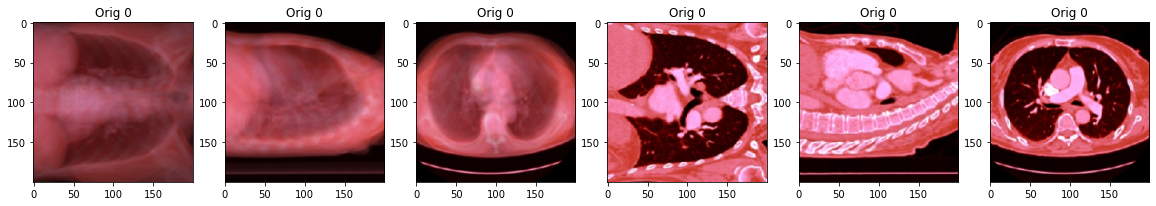

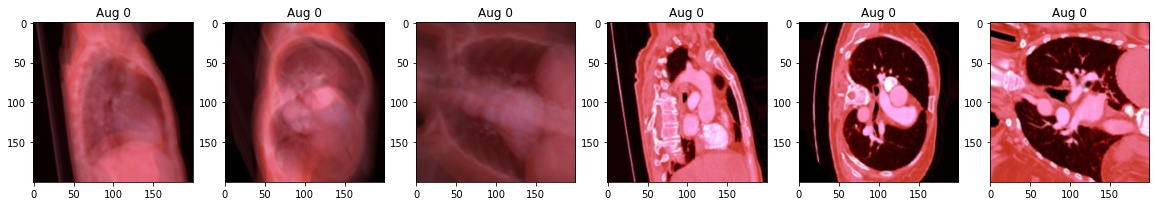

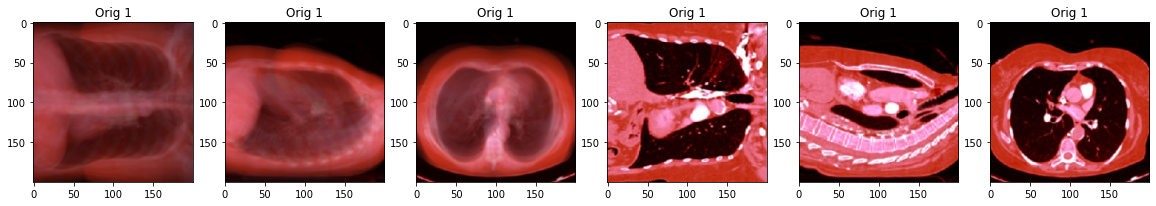

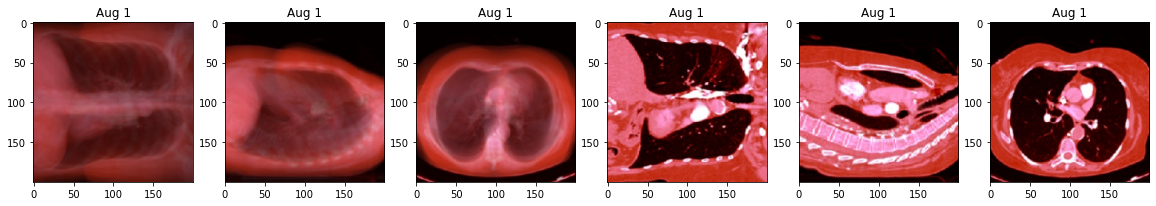

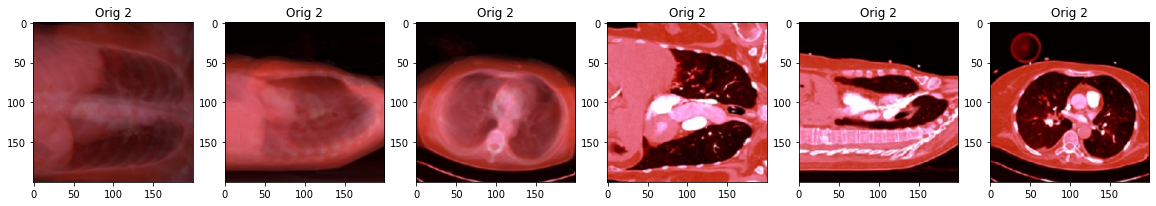

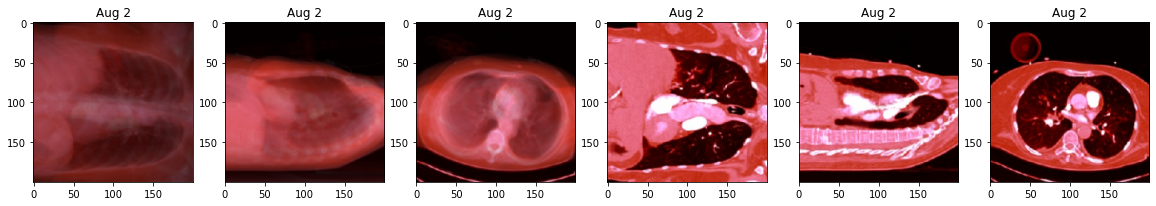

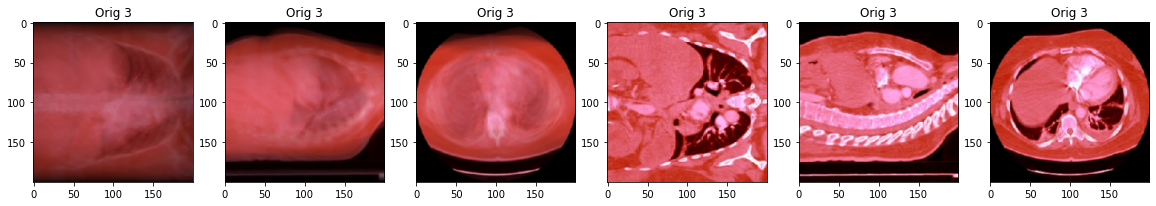

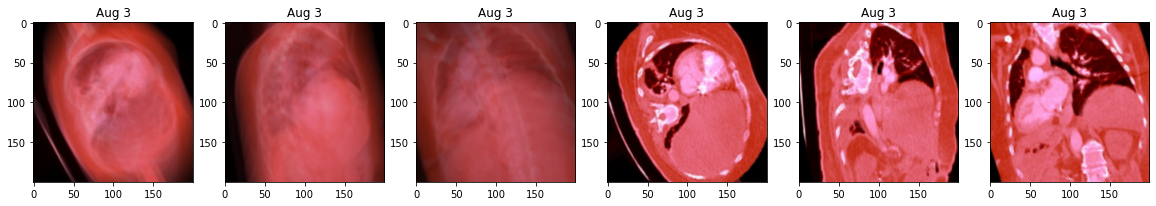

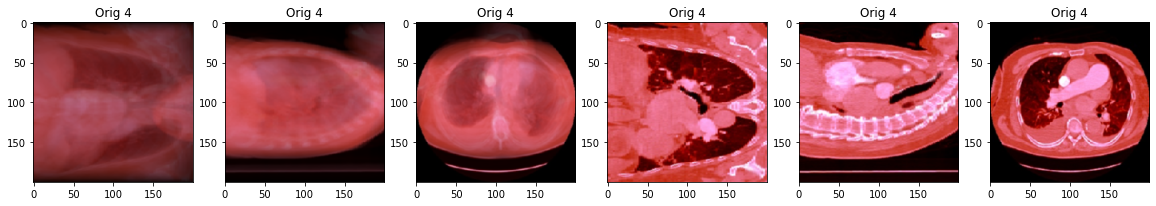

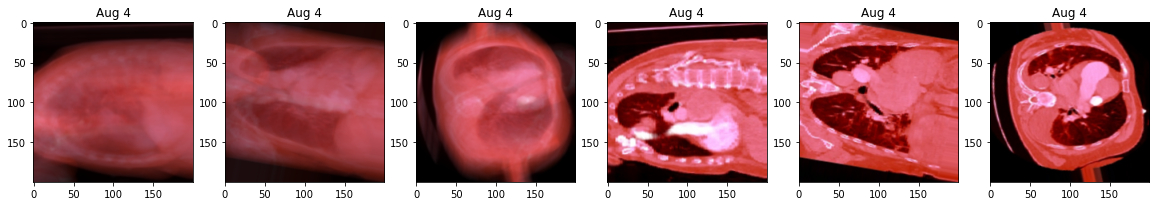

In [9]:
dataset_show = RSNADataset3D(df_study.head(5), 'train', transform=val_transforms)
dataset_show_aug = RSNADataset3D(df_study.head(5), 'train', transform=train_transforms)
from pylab import rcParams
rcParams['figure.figsize'] = 20,5
for i in range(5):
    f, axarr = plt.subplots(1,6)
    img, label = dataset_show[i]
    for j in range(6):        
        if j<=2: axarr[j].imshow(img.numpy().transpose(1,2,3,0).mean(axis=j))
        elif j==3: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[image_size//2,:,:])
        elif j==4: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,image_size//2,:])
        elif j==5: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,:,image_size//2])
        axarr[j].set_title(f"Orig {i}")
    f, axarr = plt.subplots(1,6)
    img, label = dataset_show_aug[i]    
    for j in range(6):        
        if j<=2: axarr[j].imshow(img.numpy().transpose(1,2,3,0).mean(axis=j))
        elif j==3: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[image_size//2,:,:])
        elif j==4: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,image_size//2,:])
        elif j==5: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,:,image_size//2])
        axarr[j].set_title(f"Aug {i}")
    plt.show()

## loss function

In [10]:
bce = nn.BCEWithLogitsLoss()
def criterion(logits, target): 
    loss = bce(logits.view(-1), target.view(-1))
    return loss

## training

In [11]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)       
        loss = criterion(logits, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            LOGITS.append(logits.detach().cpu())
            TARGETS.append(target.detach().cpu())

    val_loss = criterion(torch.cat(LOGITS), torch.cat(TARGETS)).numpy()
    PROBS = torch.sigmoid(torch.cat(LOGITS)).numpy().squeeze()    
    LOGITS = torch.cat(LOGITS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()
    
    if get_output:
        return LOGITS, PROBS, TARGETS
    else:
        acc = (PROBS.round() == TARGETS).mean() * 100.
        auc = roc_auc_score(TARGETS, LOGITS)
        return float(val_loss), acc, auc

In [12]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [13]:
def run(fold):
    df_train = df_study[(df_study['fold'] != fold)]
    df_valid = df_study[(df_study['fold'] == fold)]

    dataset_train = RSNADataset3D(df_train, 'train', transform=train_transforms)
    dataset_valid = RSNADataset3D(df_valid, 'val', transform=val_transforms)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, sampler=RandomSampler(dataset_train), num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=4, num_workers=num_workers)

    model = monai.networks.nets.densenet.densenet169(spatial_dims=3, in_channels=3, out_channels=out_dim).to(device)

    val_loss_best = 1000
    model_file = f'{kernel_type}_best_fold{fold}.pth'

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    if use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
#     if len(os.environ['CUDA_VISIBLE_DEVICES'].split(',')) > 1:
#         model = nn.DataParallel(model)         
        
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss, acc, auc = val_epoch(model, valid_loader)
    
        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}'
        print(content)
        with open(f'log_{kernel_type}.txt', 'a') as appender:
            appender.write(content + '\n')             
            
        if val_loss < val_loss_best:
            print('val_loss_best ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_best, val_loss))
            torch.save(model.state_dict(), model_file)
            val_loss_best = val_loss

    torch.save(model.state_dict(), f'{kernel_type}_model_fold{fold}.pth')

Note: there are some differences between code in this notebook and my local code due to Kaggle notebook hardware limitation.
* I use apex for mixed precision locally, but I don't use it here as I cannot install `apex`
* I use 2 GPUs (32G each) and 32 CPU cores locally with batch size 48, here I can only fit in batch size 8
* I use DEBUG mode in the notebook for illustration. In DEBUG mode I only train for 3 epochs using first 600 studies. Locally I train 20 epochs using all 7000 studies by setting `DEBUG = False` in the beginning

In my local setup, valid loss can go down to 0.306

In [14]:
run(fold=0)

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

741 159
Tue Oct 20 08:57:36 2020 Epoch: 1


100%|██████████| 40/40 [03:58<00:00,  5.97s/it]


Tue Oct 20 09:42:17 2020 Fold 0, Epoch 1, lr: 0.0000100, train loss: 0.57192, valid loss: 0.45527, acc: 84.9755, auc: 0.566053
val_loss_best (1000.000000 --> 0.455273).  Saving model ...


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 09:42:17 2020 Epoch: 2


100%|██████████| 40/40 [03:56<00:00,  5.91s/it]


Tue Oct 20 10:26:32 2020 Fold 0, Epoch 2, lr: 0.0000280, train loss: 0.39462, valid loss: 0.36036, acc: 85.6045, auc: 0.616675
val_loss_best (0.455273 --> 0.360363).  Saving model ...


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 10:26:32 2020 Epoch: 3


100%|██████████| 40/40 [03:55<00:00,  5.90s/it]


Tue Oct 20 11:11:12 2020 Fold 0, Epoch 3, lr: 0.0000460, train loss: 0.36045, valid loss: 0.35719, acc: 85.8141, auc: 0.605964
val_loss_best (0.360363 --> 0.357188).  Saving model ...


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 11:11:13 2020 Epoch: 4


100%|██████████| 40/40 [03:52<00:00,  5.82s/it]
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 11:55:16 2020 Fold 0, Epoch 4, lr: 0.0000640, train loss: 0.35824, valid loss: 0.36079, acc: 85.6045, auc: 0.557490
Tue Oct 20 11:55:16 2020 Epoch: 5


100%|██████████| 40/40 [03:51<00:00,  5.79s/it]
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 12:39:14 2020 Fold 0, Epoch 5, lr: 0.0000820, train loss: 0.35991, valid loss: 0.36319, acc: 85.6045, auc: 0.542746
Tue Oct 20 12:39:14 2020 Epoch: 6


100%|██████████| 40/40 [03:59<00:00,  5.98s/it]


Tue Oct 20 13:24:15 2020 Fold 0, Epoch 6, lr: 0.0001000, train loss: 0.36184, valid loss: 0.35665, acc: 85.6045, auc: 0.586766
val_loss_best (0.357188 --> 0.356649).  Saving model ...


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:942: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 13:24:15 2020 Epoch: 7


  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 14:10:27 2020 Fold 0, Epoch 7, lr: 0.0001000, train loss: 0.36044, valid loss: 0.35876, acc: 85.6045, auc: 0.583124
Tue Oct 20 14:10:27 2020 Epoch: 8


100%|██████████| 40/40 [03:46<00:00,  5.65s/it]


Tue Oct 20 14:54:37 2020 Fold 0, Epoch 8, lr: 0.0000812, train loss: 0.35813, valid loss: 0.35032, acc: 85.6045, auc: 0.596703
val_loss_best (0.356649 --> 0.350320).  Saving model ...


  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 14:54:37 2020 Epoch: 9


  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 15:37:48 2020 Fold 0, Epoch 9, lr: 0.0000611, train loss: 0.35521, valid loss: 0.35048, acc: 85.6045, auc: 0.652956
Tue Oct 20 15:37:48 2020 Epoch: 10


  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 16:20:54 2020 Fold 0, Epoch 10, lr: 0.0000389, train loss: 0.35210, valid loss: 0.36129, acc: 84.9057, auc: 0.562772
Tue Oct 20 16:20:54 2020 Epoch: 11


100%|██████████| 40/40 [03:45<00:00,  5.64s/it]


Tue Oct 20 17:03:31 2020 Fold 0, Epoch 11, lr: 0.0000188, train loss: 0.35366, valid loss: 0.34787, acc: 85.6045, auc: 0.636789
val_loss_best (0.350320 --> 0.347868).  Saving model ...


  0%|          | 0/186 [00:00<?, ?it/s]

Tue Oct 20 17:03:32 2020 Epoch: 12


100%|██████████| 40/40 [03:42<00:00,  5.57s/it]


Tue Oct 20 17:45:59 2020 Fold 0, Epoch 12, lr: 0.0000050, train loss: 0.34742, valid loss: 0.34599, acc: 85.9539, auc: 0.642420
val_loss_best (0.347868 --> 0.345991).  Saving model ...
